In [13]:
from data_preprocess import *
from train_and_test import *
import os
import re
import yaml
from typing import List, Dict

In [5]:
def parse_model_filename(filename, pattern=r"exp-(\d+)_(\w+)_s-(\d+)\.pth"):
    match = re.match(pattern, filename)

    if match:
        exp_num = int(match.group(1))     
        model_name = match.group(2)  
        s_num = int(match.group(3))     
        return exp_num, model_name, s_num
    raise ValueError(f"不符合预期格式的文件名：{filename}")

In [17]:
dir = 'saved_models'
test_models = {
    'lstm': [3, 5],
    'gru': [4],
    'det': [4, 5]
}

# 获取配置参数
with open('config.yaml', 'r', encoding='utf-8') as file:
    config = yaml.safe_load(file)
data_config, models_config, start_points, model_save_dir, seeds = (
    config['data']['CALCE'],       # 仅使用 CALCE
    config['models'],
    config['start_points'],        # [0.3, 0.5, 0.7]
    config['model_save_dir'],
    config['seeds']
)
data_path, test_bat, seq_length, rated_capacity, failure_threshold = (
    data_config['data_path'],
    data_config['test_bat'],
    data_config['seq_length'],
    data_config['rated_capacity'],
    data_config['failure_threshold']
)
device = torch.device(config['device'] if torch.cuda.is_available() else "cpu")

# 画图：指定模型文件范围，不同预测起始点（0.0、0.3、0.5、0.7）
# 1. 初始化结果字典
results = {}
for sp in start_points:
    results[sp] = {}

# 2. 获取数据
norm_data, failure_time = read_and_norm(data_path, rated_capacity, failure_threshold)
_, actual_seq = split_data(norm_data, test_bat)

for filename in os.listdir(dir):
    exp_num, model_name, s_num = parse_model_filename(filename)

    # 3. 加载模型
    model_config = models_config[model_name]
    model_path = os.path.join(dir, filename)
    model = get_model(model_config, device)
    model.load_state_dict(torch.load(model_path))
        
    # 4. 预测：生成预测曲线（字典，key: {sp}, subkey: '{model_name}_s-{s_num}'，val: pred_seq）
    for sp in start_points:
        pred_seq = predict(model_config, model, sp, actual_seq, seq_length, failure_threshold, device)
        model_key = f'{model_name}_s-{s_num}'
        results[sp][model_key] = pred_seq

# 5. 画图：一个sp对应一张图
for sp, pred_seqs in results.items():
    plot(actual_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)



/var/folders/6x/w_phznyd4830j7jb8y12rhrc0000gn/T/ipykernel_23571/3361881004.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

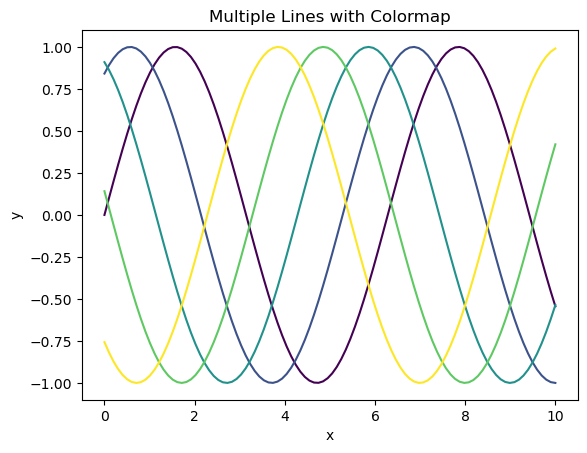

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# 数据
x = np.linspace(0, 10, 100)
y_values = [np.sin(x + i) for i in range(5)]

# 使用 colormap
colors = cm.viridis(np.linspace(0, 1, len(y_values)))

for y, color in zip(y_values, colors):
    plt.plot(x, y, color=color)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Multiple Lines with Colormap")
plt.show()